## EDA – Análise Exploratória dos Dados (SIM – I21.9)
**Objetivo:** Entendimento inicial, identificação de padrões e avaliação da qualidade dos dados  
**Autor:** Vitor Amadeu


# 1. IMPORTAÇÕES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. CONFIGURAÇÕES

In [4]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 3. CARGA DOS DADOS

In [8]:
df = pd.read_csv('D:/Analise_de_dados_SIM/Data/raw/dataset_I219.csv', encoding='latin1', low_memory=False)
print('Dimensão do dataset:')
display(df.shape)

Dimensão do dataset:


(1144980, 93)

# 4. VISÃO GERAL DOS DADOS

In [9]:
print('Tipos de variáveis:')
display(df.dtypes)

print('Valores ausentes por coluna:')
display(df.isna().sum().sort_values(ascending=False).head(15))

Tipos de variáveis:


CONTADOR      float64
ORIGEM          int64
TIPOBITO        int64
DTOBITO         int64
HORAOBITO      object
               ...   
TPRESGINFO    float64
TPNIVELINV     object
NUDIASINF     float64
FONTESINF      object
ALTCAUSA      float64
Length: 93, dtype: object

Valores ausentes por coluna:


CAUSAMAT      1144980
UFINFORM      1144980
NUDIASINF     1144977
ACIDTRAB      1144974
SERIESCMAE    1144972
SEMAGESTAC    1144968
ESCMAEAGR1    1144966
ESCMAE2010    1144962
IDADEMAE      1144960
DTCONCASO     1144959
ALTCAUSA      1144944
DTCADINF      1144938
MORTEPARTO    1144938
ESTABDESCR    1144900
PESO          1144892
dtype: int64

# 5. VARIÁVEIS DEMOGRÁFICAS

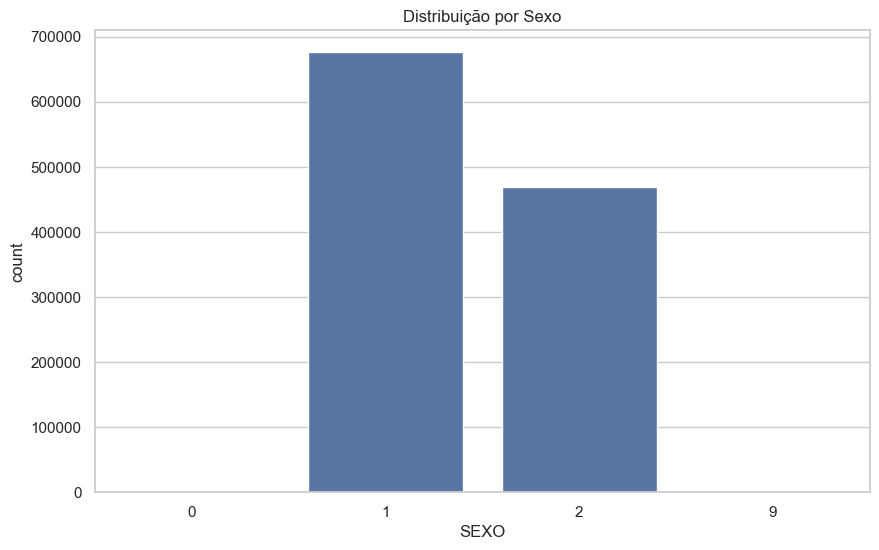

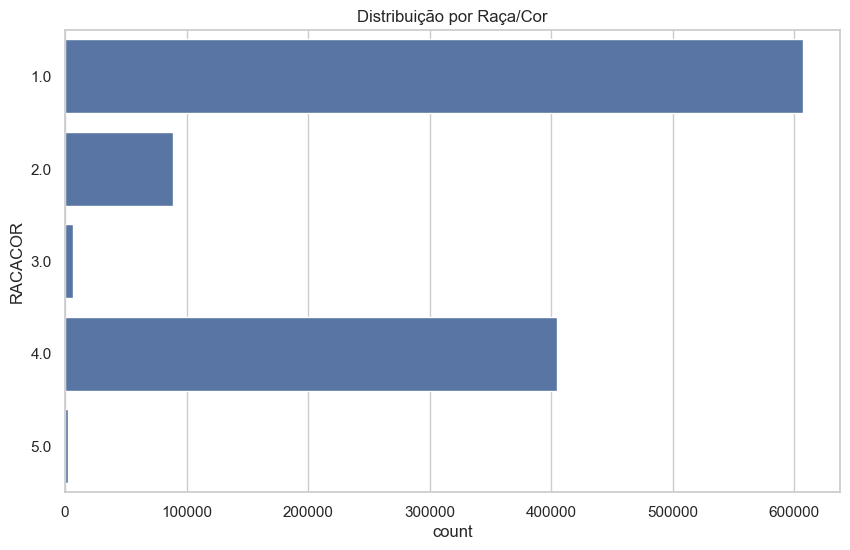

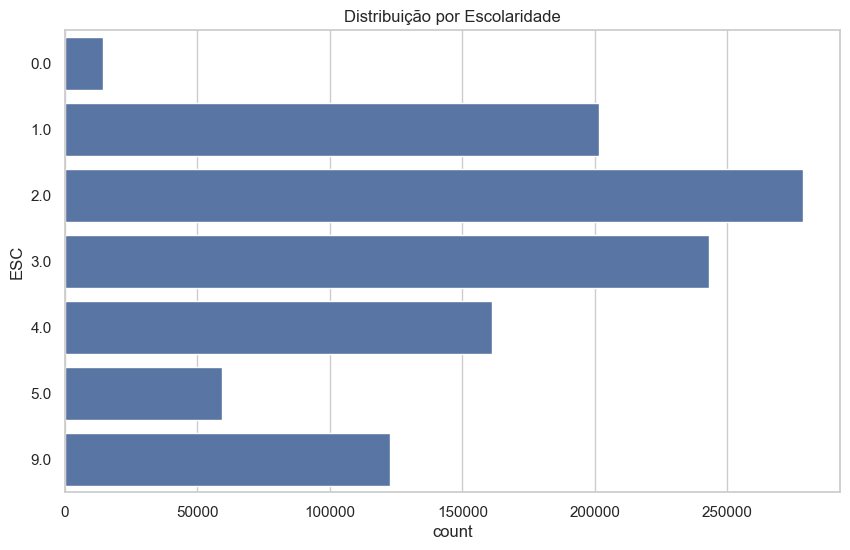

In [10]:
# Sexo
plt.figure()
sns.countplot(x='SEXO', data=df)
plt.title('Distribuição por Sexo')
plt.show()


# Raça/Cor
plt.figure()
sns.countplot(y='RACACOR', data=df)
plt.title('Distribuição por Raça/Cor')
plt.show()


# Escolaridade
plt.figure()
sns.countplot(y='ESC', data=df)
plt.title('Distribuição por Escolaridade')
plt.show()

# 6. IDADE – ANÁLISE EXPLORATÓRIA

In [13]:
def transformar_idade(codigo):
    if pd.isna(codigo):
        return None
    codigo = str(int(codigo)).zfill(3)
    unidade = int(codigo[0])
    valor = int(codigo[1:])
    if unidade == 0:
        return valor / (60 * 24 * 365)
    elif unidade == 1:
        return valor / (24 * 365)
    elif unidade == 2:
        return valor / 365
    elif unidade == 3:
        return valor / 12
    elif unidade == 4:
        return valor
    elif unidade == 5:
        return 100 + valor
    return None

In [14]:
# Conversão
df['Idade'] = df['IDADE'].apply(transformar_idade)

In [28]:
df["Idade"].head()

0    98.0
1    70.0
2    47.0
3    33.0
4    64.0
Name: Idade, dtype: float64

In [ ]:
# Estatísticas descritivas
print('Estatísticas da Idade:')
display(df['Idade'].describe())

Estatísticas da Idade:


count    1.143873e+06
mean     6.916525e+01
std      1.459436e+01
min      4.756469e-05
25%      5.900000e+01
50%      7.000000e+01
75%      8.000000e+01
max      1.200000e+02
Name: Idade, dtype: float64

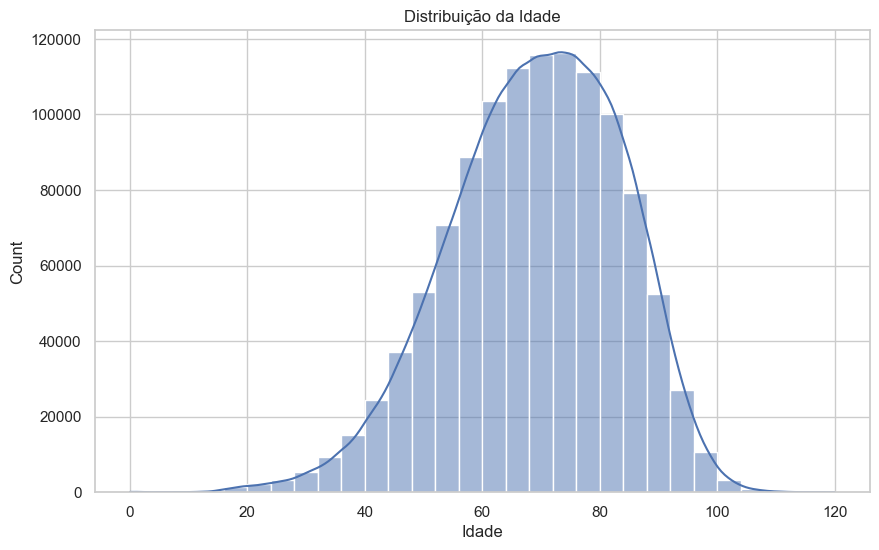

In [16]:
# Histograma
plt.figure()
sns.histplot(df['Idade'], bins=30, kde=True)
plt.title('Distribuição da Idade')
plt.show()

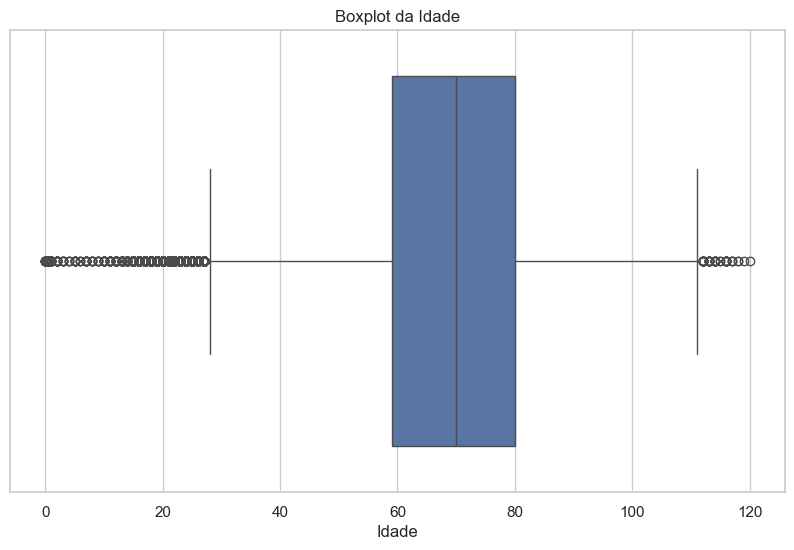

In [17]:
# Boxplot
plt.figure()
sns.boxplot(x=df['Idade'])
plt.title('Boxplot da Idade')
plt.show()

# 7. ANÁLISE TEMPORAL EXPLORATÓRIA

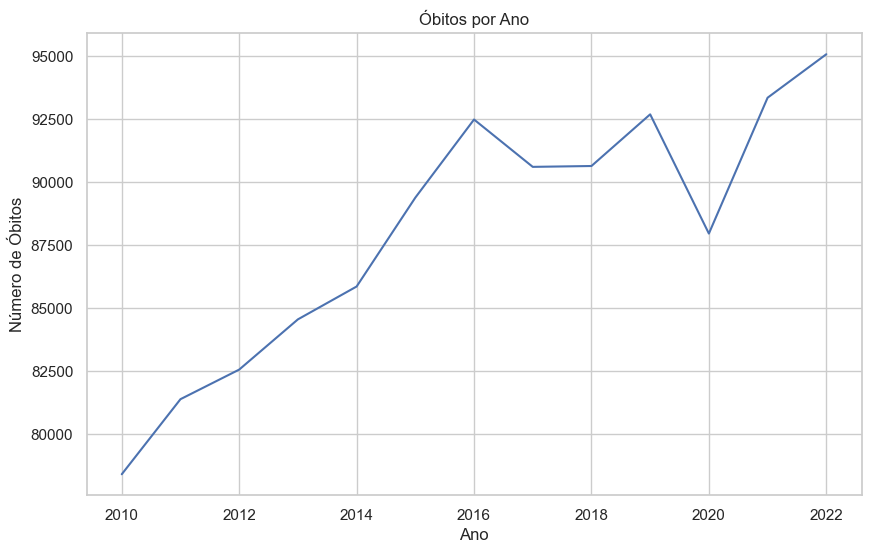

In [18]:
# Extração de data
df['DTOBITO'] = df['DTOBITO'].astype(str).str.zfill(8)
df['ANO_OBITO'] = df['DTOBITO'].str[4:].astype(int)
df['MES_OBITO'] = df['DTOBITO'].str[2:4].astype(int)


# Óbitos por ano
obitos_ano = df.groupby('ANO_OBITO').size()

plt.figure()
obitos_ano.plot()
plt.title('Óbitos por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Óbitos')
plt.grid(True)
plt.show()

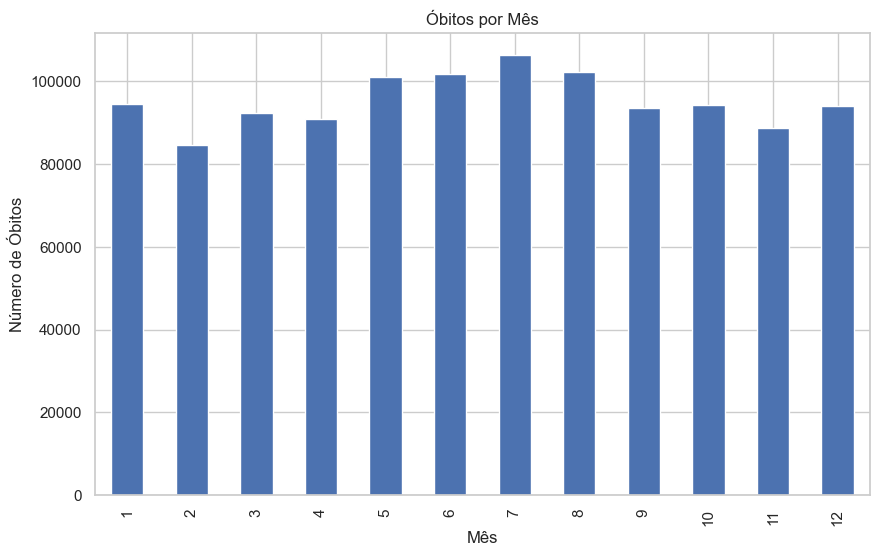

In [19]:
# Óbitos por mês (sazonalidade)
obitos_mes = df.groupby('MES_OBITO').size()


plt.figure()
obitos_mes.plot(kind='bar')
plt.title('Óbitos por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Óbitos')
plt.show()

# 8. ANÁLISE GEOGRÁFICA EXPLORATÓRIA

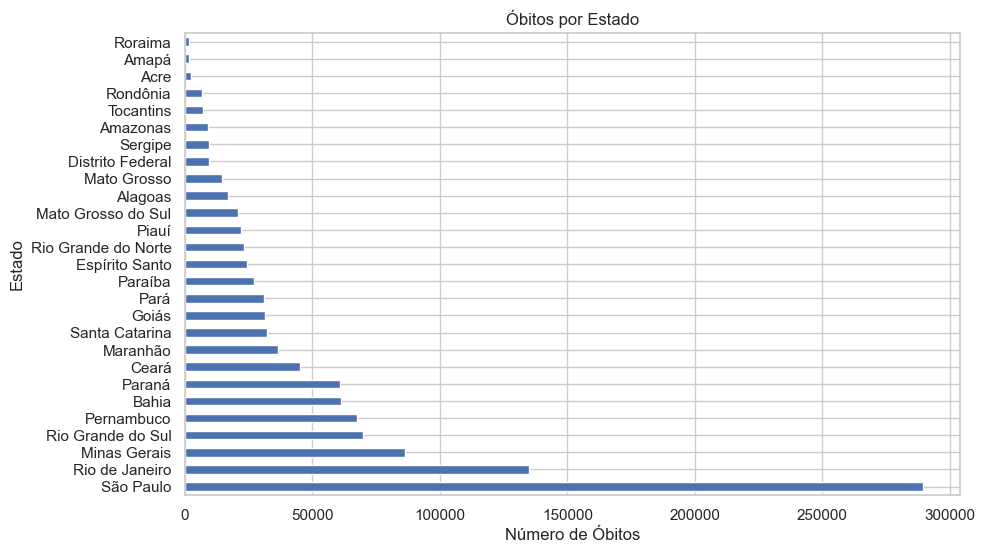

In [22]:
def mapear_estado(codigo):
    ufs = {
    "11": "Rondônia", "12": "Acre", "13": "Amazonas", "14": "Roraima",
    "15": "Pará", "16": "Amapá", "17": "Tocantins", "21": "Maranhão",
    "22": "Piauí", "23": "Ceará", "24": "Rio Grande do Norte",
    "25": "Paraíba", "26": "Pernambuco", "27": "Alagoas",
    "28": "Sergipe", "29": "Bahia", "31": "Minas Gerais",
    "32": "Espírito Santo", "33": "Rio de Janeiro", "35": "São Paulo",
    "41": "Paraná", "42": "Santa Catarina", "43": "Rio Grande do Sul",
    "50": "Mato Grosso do Sul", "51": "Mato Grosso",
    "52": "Goiás", "53": "Distrito Federal"
    }
    return ufs.get(str(codigo)[:2], 'Desconhecido')


# Aplicação
df['Estado'] = df['CODMUNOCOR'].apply(mapear_estado)


# Ranking por estado
plt.figure()
df['Estado'].value_counts().plot(kind='barh')
plt.title('Óbitos por Estado')
plt.xlabel('Número de Óbitos')
plt.show()

# 9. COMORBIDADES – VISÃO EXPLORATÓRIA

In [26]:
CID_COLUMNS = ['LINHAA','LINHAB','LINHAC','LINHAD','LINHAII','CAUSABAS_O']


def criar_indicador_cid(df, lista_cids, nome_coluna):
    def verificar(row):
        for col in CID_COLUMNS:
            if pd.notna(row[col]) and any(cid in row[col] for cid in lista_cids):
                return 1
            return 0
    df[nome_coluna] = df.apply(verificar, axis=1)
    return df


# Indicadores
df = criar_indicador_cid(df, ['E66','Z680','Z681','Z682','Z683','Z684'], 'Obesidade')
df = criar_indicador_cid(df, ['I10X'], 'Hipertensao')
df = criar_indicador_cid(df, ['E149'], 'Diabetes')
df = criar_indicador_cid(df, ['F172','F171','F179'], 'Tabaco')


# Frequência
comorbidades = df[['Obesidade','Hipertensao','Diabetes','Tabaco']].mean()*100

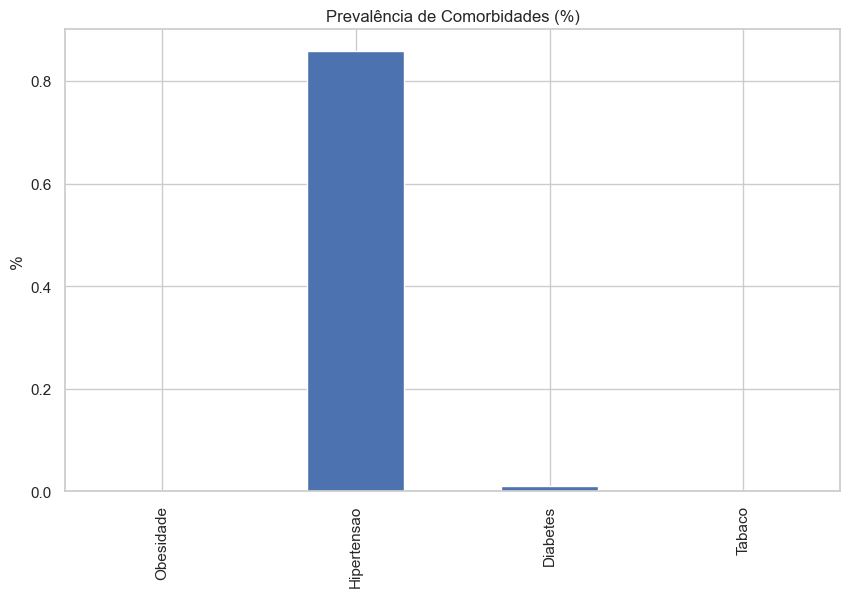

In [27]:
plt.figure()
comorbidades.plot(kind='bar')
plt.title('Prevalência de Comorbidades (%)')
plt.ylabel('%')
plt.show()